In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BartTokenizer

In [2]:
df = pd.read_csv("clean.csv")
df = df.dropna(subset=['text', 'title'])
df = df.rename(columns={"text": "article", "title": "headline"})

In [3]:
df.head()

,headline,article,url
0,"'80s supermodel Kim Alexis, 64, talks the 'pre...",Kim Alexis was a regular on the cover of the S...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
1,Buffy The Vampire Slayer fans in meltdown over...,Buffy fans were left overwhelmed with exciteme...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
2,Cristiano Ronaldo's girlfriend hit Met Gala in...,Cristiano Ronaldo's girlfriend made her debut ...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
3,Conor McGregor's fiancée Dee Devlin shares def...,Conor McGregor and fiancée Dee Devlin issued a...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...
4,"Has Liam Neeson finally found Love, Actually a...",'I'm madly in love with her. She's just terrif...,https://www.dailymail.co.uk/tvshowbiz/tvshowbi...


# General Data Quality and Distribution Analysis

### Sequence Length Distribution (Article vs. Headline)

In [4]:
# Add new columns for word counts
df['article_len'] = df['article'].str.split().apply(len)
df['headline_len'] = df['headline'].str.split().apply(len)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

# Calculate tokenized length
df['article_len'] = df['article'].apply(lambda x: len(tokenizer.tokenize(x)))
df['headline_len'] = df['headline'].apply(lambda x: len(tokenizer.tokenize(x)))


W0722 10:32:34.998000 47188 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


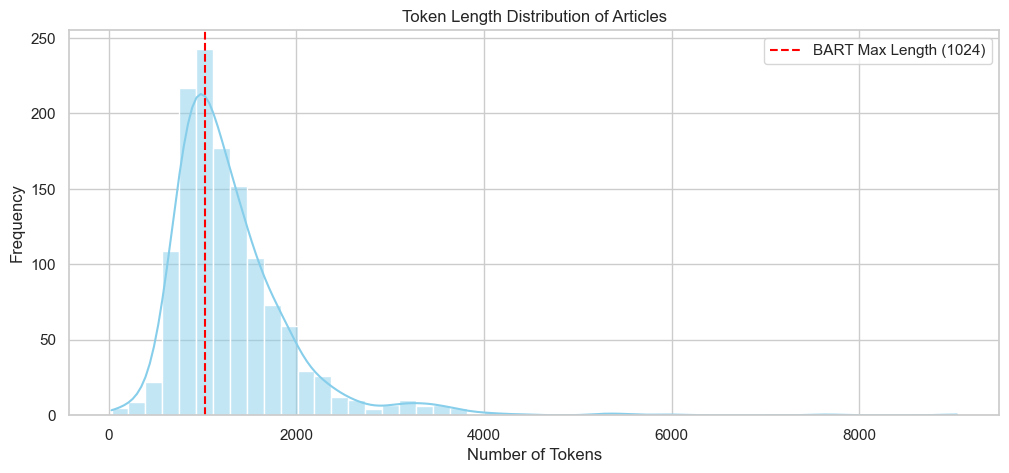

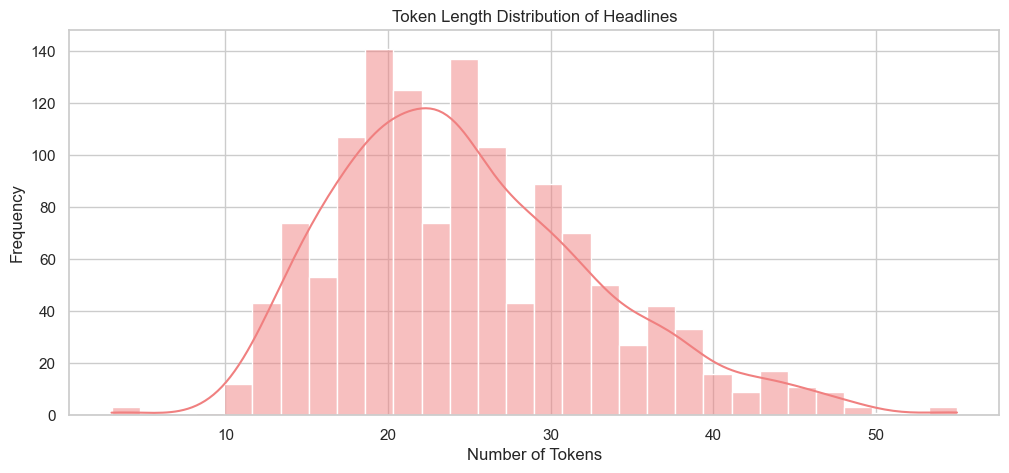

In [5]:
# Set plot style
sns.set(style="whitegrid")

# Plot article lengths
plt.figure(figsize=(12, 5))
sns.histplot(df['article_len'], bins=50, color='skyblue', kde=True)
plt.title("Token Length Distribution of Articles")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.axvline(x=1024, color='red', linestyle='--', label='BART Max Length (1024)')
plt.legend()
plt.show()

# Plot headline lengths
plt.figure(figsize=(12, 5))
sns.histplot(df['headline_len'], bins=30, color='lightcoral', kde=True)
plt.title("Token Length Distribution of Headlines")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


In [6]:
print("Articles:\n", df['article_len'].describe())
print("Headlines:\n", df['headline_len'].describe())

# Spot very short or very long sequences
short_articles = df[df['article_len'] < 50]
long_articles = df[df['article_len'] > 1024]

short_headlines = df[df['headline_len'] < 3]
long_headlines = df[df['headline_len'] > 25]


Articles:
 count    1296.000000
mean     1314.952932
std       694.283377
min        32.000000
25%       899.000000
50%      1151.000000
75%      1552.250000
max      9039.000000
Name: article_len, dtype: float64
Headlines:
 count    1296.000000
mean       24.846451
std         8.085854
min         3.000000
25%        19.000000
50%        24.000000
75%        30.000000
max        55.000000
Name: headline_len, dtype: float64


In [13]:
#decision: delete the headline_len < 10 
df = df[df['headline_len']>10].reset_index(drop=True)

### Vocabulary Size and Token Frequency

In [13]:
import re

def clean_text(text):
    # Lowercase, remove special characters (keeping words and spaces), normalize spacing
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_article'] = df['article'].apply(clean_text)
df['clean_headline'] = df['headline'].apply(clean_text)


In [14]:
from transformers import BartTokenizer
from collections import Counter

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

def get_tokens(text_series):
    tokens = []
    for text in text_series:
        tokens.extend(tokenizer.tokenize(text))
    return tokens

# Get token lists
article_tokens = get_tokens(df['clean_article'])
headline_tokens = get_tokens(df['clean_headline'])

# Token frequency
article_freq = Counter(article_tokens)
headline_freq = Counter(headline_tokens)


In [15]:
# Unique token counts
article_vocab_size = len(article_freq)
headline_vocab_size = len(headline_freq)

print(f"📘 Article Vocabulary Size: {article_vocab_size}")
print(f"📰 Headline Vocabulary Size: {headline_vocab_size}")


📘 Article Vocabulary Size: 23267
📰 Headline Vocabulary Size: 6366


In [16]:
print("🔝 Most common article tokens:")
print(article_freq.most_common(10))

print("\n🔝 Most common headline tokens:")
print(headline_freq.most_common(10))

print("\n🔻 Least frequent article tokens:")
print([token for token, count in article_freq.items() if count == 1][:10])


🔝 Most common article tokens:
[('Ġthe', 62436), ('Ġand', 32545), ('Ġa', 32360), ("Ġ'", 31895), ('Ġto', 31320), ('Ġin', 26990), ('Ġof', 24217), ('Ġher', 14567), ('Ġon', 13829), ('Ġwith', 12808)]

🔝 Most common headline tokens:
[("'", 540), ("Ġ'", 516), ('Ġin', 502), ("'s", 474), ('Ġto', 473), ('Ġthe', 458), ('Ġand', 408), ('Ġas', 404), ('Ġa', 362), ('Ġafter', 332)]

🔻 Least frequent article tokens:
['Ġcontemporaries', 'fortable', 'confidence', 'abl', 'impact', 'Ġcoats', 'atures', 'dinand', 'ventus', 'Ġacad']


In [17]:
# Get BART's vocabulary set
bart_vocab = set(tokenizer.get_vocab().keys())

def compute_oov_rate(token_list):
    oov_count = sum(1 for token in token_list if token not in bart_vocab)
    return oov_count / len(token_list)

article_oov_rate = compute_oov_rate(article_tokens)
headline_oov_rate = compute_oov_rate(headline_tokens)

print(f"🚫 OOV Rate (Articles): {article_oov_rate:.2%}")
print(f"🚫 OOV Rate (Headlines): {headline_oov_rate:.2%}")


🚫 OOV Rate (Articles): 0.00%
🚫 OOV Rate (Headlines): 0.00%


+ No Out-of-Vocabulary (OOV) Tokens: 
Every token in both articles and headlines is present in the BART tokenizer's vocabulary.

# Clickbait Specificity and Quality Evaluation